## ***CE-672 Assignment - 02***
### **Amipriya Anand (220122)**

In [1]:
# import necessary libraries
import rasterio
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# Define file paths for imagery and leader metadata
image_file = "IMAGERY.L-3"   # Image data
leader_file = "LEADER.L-3"   # Metadata
selected_file = None

In [3]:
# defining a function that will give all the meta data for the image file as well as additional data form leader file
def extract_metadata(leader_path, image_path):
    """
    Reads and extracts metadata from the leader file.
    """
    metadata = {}
    
    try:
        with rasterio.open(image_path) as img_dat:
            metadata = img_dat.meta
        with open(leader_path, "rb") as file:
            file.seek(21)  # Orbit Path
            metadata["Orbit Path"] = file.read(8).decode('ascii', errors='ignore').strip()

            file.seek(29)  # Scene Row
            metadata["Scene Row"] = file.read(6).decode('ascii', errors='ignore').strip()

            file.seek(37)  # Scene ID
            metadata["Scene ID"] = file.read(32).decode('ascii', errors='ignore').strip()

            file.seek(101)  # Latitude
            metadata["Latitude"] = file.read(16).decode('ascii', errors='ignore').strip()

            file.seek(117)  # Longitude
            metadata["Longitude"] = file.read(16).decode('ascii', errors='ignore').strip()

            file.seek(357)  # Pixel Size
            metadata["Pixel Size (m)"] = file.read(8).decode('ascii', errors='ignore').strip()

            file.seek(574)  # Sun Azimuth
            metadata["Sun Azimuth (°)"] = file.read(16).decode('ascii', errors='ignore').strip()

            file.seek(590)  # Sun Elevation
            metadata["Sun Elevation (°)"] = file.read(16).decode('ascii', errors='ignore').strip()
    
    except Exception as e:
        print(f"Error extracting metadata: {e}")
    
    return metadata


In [4]:

# Extract and display metadata
metadata_info = extract_metadata(leader_file,image_file)
metadata_info


C:\Users\amipr\AppData\Roaming\Python\Python311\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'driver': 'CEOS',
 'dtype': 'uint8',
 'nodata': None,
 'width': 6357,
 'height': 5976,
 'count': 4,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0),
 'Orbit Path': 'PF12-95',
 'Scene Row': '1  IRS',
 'Scene ID': 'DPSR1V1   1LEADER FILE     FSEQ',
 'Latitude': '9   4YNNN',
 'Longitude': '',
 'Pixel Size (m)': '2',
 'Sun Azimuth (°)': '',
 'Sun Elevation (°)': ''}

#### **Creating the Attributes (Commands) for the GUI**

In [5]:
# this will open dialog box to select the file in the gui
# for taking the image file as input
def select_file():
    """
    Opens a file dialog to select the IMAGERY.L-3 file.
    """
    global selected_file
    selected_file = filedialog.askopenfilename(title="Select IMAGERY.L-3 File")
    if selected_file:
        messagebox.showinfo("File Selected", f"Selected: {selected_file}")


In [6]:
def display_meta_data():
    """
    Displays Meta data
    """
    if not selected_file:
        messagebox.showerror("Error", "Please select an image file first.")
        return
    meta_info = extract_metadata(leader_file,selected_file)
    meta_text = "\n".join([f"{key}:\t{value}" for key,value in meta_info.items()])
    messagebox.showinfo("Meta data", meta_text)
    

In [7]:
def load_image(image_path, color_mode="Grey"):
    """
    Reads the image file and returns a grayscale or color (FCC) image.
    
    - If `color_mode == "Grey"`: Reads only Band 1 (Grayscale).
    - If `color_mode == "Color"`: Reads Bands 1, 2, and 3 (False Color Composite).
    """
    try:
        with rasterio.open(image_path) as img:
            if color_mode == "Grey":
                # Read a single grayscale band
                band1 = img.read(1).astype(np.float32)
                band1 = ((band1 - np.min(band1)) / (np.max(band1) - np.min(band1))) * 255
                return band1.astype(np.uint8)

            elif color_mode == "Color":
                # Read 3 bands for color composite (RGB or FCC)
                band1 = img.read(1).astype(np.float32)  # Red
                band2 = img.read(2).astype(np.float32)  # Green
                band3 = img.read(3).astype(np.float32)  # Blue

                # Normalize bands to 8-bit (0-255) range
                band1 = ((band1 - np.min(band1)) / (np.max(band1) - np.min(band1))) * 255
                band2 = ((band2 - np.min(band2)) / (np.max(band2) - np.min(band2))) * 255
                band3 = ((band3 - np.min(band3)) / (np.max(band3) - np.min(band3))) * 255

                # Convert to uint8 and stack into a 3-channel image
                return np.dstack((band1.astype(np.uint8), band2.astype(np.uint8), band3.astype(np.uint8)))

    except Exception as e:
        messagebox.showerror("Error", f"Error loading image: {e}")
        return None


In [8]:
def display_image():
    """
    Displays the selected image in either Grey or Color mode.
    """
    if not selected_file:
        messagebox.showerror("Error", "Please select an image file first.")
        return

    global lut_type
    image_data = load_image(selected_file, color_mode=lut_type)
    if image_data is None:
        return

    # Display the image
    plt.imshow(image_data, cmap="gray" if lut_type == "Grey" else None)
    plt.title(f"Displayed Image - {lut_type} Mode")
    plt.axis("off")
    plt.show()


In [9]:
# function to set lut type : grey or coloured
def set_lut(type_choice):
    """
    Sets the LUT mode to either 'Grey' or 'Color'.
    """
    global lut_type
    lut_type = type_choice
    messagebox.showinfo("LUT Set", f"LUT mode set to: {lut_type}")


In [10]:
# function to save the image file by cropping in the desired no. of row s and coloumns 
def extract_and_save_subset():
    """
    Extracts a subset of the image based on user input.
    If any field is left empty, default values from metadata are used.
    """
    if not selected_file:
        messagebox.showerror("Error", "Please select an image file first.")
        return

    try:
        # Load the full image
        image_data = load_image(selected_file, color_mode=lut_type)
        if image_data is None:
            return
        
        # Get image dimensions (Height = Rows, Width = Columns)
        image_height, image_width = image_data.shape[:2]  # Works for both Grey & Color modes

        # Fetch metadata defaults (assuming metadata_info contains these values)
        default_min_row = 0
        default_max_row = metadata_info.get("Input nominal scene data (lines)", image_height)
        default_min_col = 0
        default_max_col = metadata_info.get("Input nominal scene data (pixels)", image_width)

        # Read user input, use defaults if empty
        min_row = int(min_row_entry.get()) if min_row_entry.get() else default_min_row
        max_row = int(max_row_entry.get()) if max_row_entry.get() else default_max_row
        min_col = int(min_col_entry.get()) if min_col_entry.get() else default_min_col
        max_col = int(max_col_entry.get()) if max_col_entry.get() else default_max_col

        # Ensure cropping values are within valid range
        min_row, max_row = max(0, min_row), min(image_height, max_row)
        min_col, max_col = max(0, min_col), min(image_width, max_col)

        if min_row >= max_row or min_col >= max_col:
            messagebox.showerror("Error", "Invalid crop dimensions.")
            return

        # Crop image
        subset = image_data[min_row:max_row, min_col:max_col]

        # Get filename to save
        save_file = filedialog.asksaveasfilename(defaultextension=".tiff",
                                                 filetypes=[("TIFF files", "*.tiff"), ("BMP files", "*.bmp")])
        if save_file:
            Image.fromarray(subset).save(save_file)
            messagebox.showinfo("Success", f"Subset saved as {save_file}")

    except Exception as e:
        messagebox.showerror("Error", f"Error extracting/saving subset: {e}")


#### ****Create the Main GUI****


In [11]:
# Create the main GUI window
root = tk.Tk()
root.title("My(220122) IMAGE Viewer")
root.geometry("400x400")

''

In [12]:
# Buttons for file selection and LUT choice
tk.Button(root, text="Select IMAGERY.L-3 File", command=select_file).pack(pady=5)
tk.Button(root, text="Display Metadata", command=display_meta_data).pack(pady=2)
tk.Button(root, text="Display in Grey", command=lambda: set_lut("Grey")).pack(pady=2)
tk.Button(root, text="Display in Color", command=lambda: set_lut("Color")).pack(pady=2)
tk.Button(root, text="Show Image", command=display_image).pack(pady=5)

# Input fields for cropping
tk.Label(root, text="Min Row:").pack()
min_row_entry = tk.Entry(root)
min_row_entry.pack()

tk.Label(root, text="Max Row:").pack()
max_row_entry = tk.Entry(root)
max_row_entry.pack()

tk.Label(root, text="Min Col:").pack()
min_col_entry = tk.Entry(root)
min_col_entry.pack()

tk.Label(root, text="Max Col:").pack()
max_col_entry = tk.Entry(root)
max_col_entry.pack()

# Button to save cropped image
tk.Button(root, text="Extract and Save Subset", command=extract_and_save_subset).pack(pady=5)

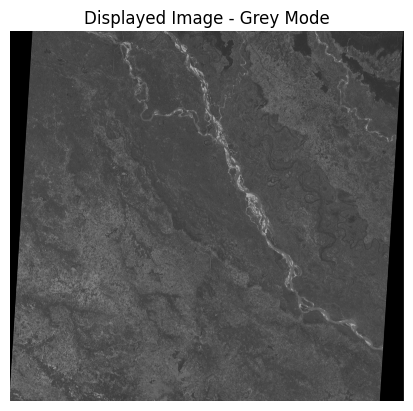

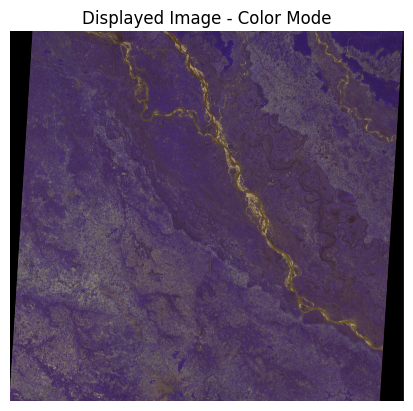

In [13]:
root.mainloop()